# Fouth model: Random forest with TFIDF + complexity features

In [2]:
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

In [98]:
import time
start = time.time()

import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

import gc

In [4]:
df = pd.read_csv('~/TFM_fake_news_detector/data/corpus_features.csv', index_col = 0)

In [5]:
df_index = df.index

In [6]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and sºtoring in another column
df['Labels'] = labelencoder.fit_transform(df['Category'])

# True == 1 and False == 0
y = df['Labels']

## TfidfVectorizer

The TfidfVectorizer serves us to convert a collection of raw documents into a matrix of TF and IDF features.

### IDF (Inverse Document Frequency)

The IDF is used to calculate how many times a word appears on a set of documents.

### TF (Term Frequency)

The TF, unlike the IDF is the number of times a word appears in a single document.

## Spanish tokenization

    - Spanish stopwords
    - Added more spanish punctuation
    - Created stems with lemmas, using the rooting word

In [7]:
#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

In [8]:
#Spanish stemmer: Stemming is the process to transform any word into its rooting word, considering them as the same word
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [9]:
#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

In [10]:
def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TFIDF Vectorizer transformation with the tokenization explaned

In [11]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

### Transformation

In [12]:
text_vectorized = tfidf_vectorizer.fit_transform(df['Text']) 

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
tfvocab = tfidf_vectorizer.get_feature_names()

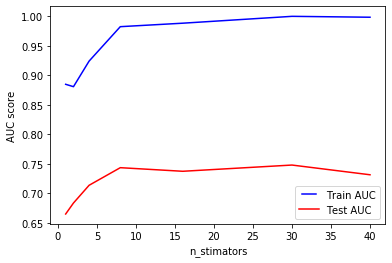

In [28]:
n_estimators = [1, 2, 4, 8, 16, 30, 40]
train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
line1, = plt.plot(n_estimators, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('AUC score')
plt.xlabel('n_stimators')
plt.show()

### Make Dense dataframe Sparse, and Combine with TF-IDF features

In [29]:
categorical_features = ['sentences', 'n_words', 'avg_words_sent', 'avg_word_size', 'TTR']

X = hstack([csr_matrix(df[categorical_features].values), text_vectorized[0:]])
tfvocab = df[categorical_features].columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(tfvocab))
gc.collect();

971 Rows and 15569 Cols
Feature Names Length:  15569


### Split into testing set, training set and validation set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

# Random Forest

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8121596244131455

## Random Forest hyperparameters grid search:

    n_estimators = number of trees in the foreset

    max_features = max number of features considered for splitting a node

    max_depth = max number of levels in each decision tree

    min_samples_split = min number of data points placed in a node before the node is split

    min_samples_leaf = min number of data points allowed in a leaf node

    bootstrap = method for sampling data points (with or without replacement)

In [69]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [74]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state = 42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [75]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [97]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    score = accuracy_score(y_test, y_pred)
    accuracy = round(score * 100, 2)
    print('Model Performance')
    print('Average Error: %f degrees.' %(np.mean(errors)))
    print(f'Accuracy: {round(score * 100, 2)}%')
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)


best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of %f.' %( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.270548 degrees.
Accuracy: 72.95%
Model Performance
Average Error: 0.167808 degrees.
Accuracy: 83.22%
Improvement of 14.078136.


## Grid search with cross validation

In [102]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 85, 90, 95],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 1000, 1800]
}

In [103]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [104]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 17.9min finished


{'bootstrap': True, 'max_depth': 95, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1800}
Model Performance
Average Error: 0.157534 degrees.
Accuracy: 84.25%
Improvement of 15.49%.


## Predictions & results

In [105]:
y_pred = best_grid.predict(X_test)

In [106]:
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 84.25%


In [107]:
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
print(cf_matrix)

[[119  31]
 [ 15 127]]


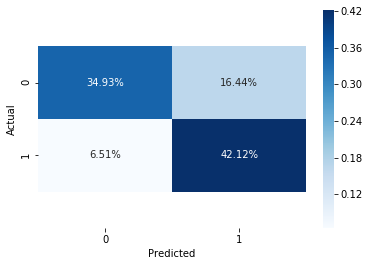

In [33]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()